In [1]:
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import animation, rc
import matplotlib.colors as colors
from IPython.display import HTML

First attempt using spectral ratio didn't work too well.  So a new approach working under the assumption that during the earlier stages of a peat fire's life cycle surficial fires will perhaps predominate.  To assess this we can look at the BT characteristics of a given fire and its associated pixels as they progress through time.  

In [4]:
# read in the himawari lat and lon data
geo_file = '/Users/danielfisher/Projects/kcl-fire-aot/data/Asia/processed/himawari/Himawari_lat_lon.img'
geostationary_lats, geostationary_lons = geo_read(geo_file)

In [5]:
fires_df = pd.read_pickle('/Users/danielfisher/Projects/kcl-fire-aot/data/Asia/processed/himawari/updated/frp_df.p')

In [6]:
# spatial subset to ROI
mask = ((fires_df.LATITUDE > -7) & (fires_df.LATITUDE < 4) & 
        (fires_df.LONGITUDE > 94) & (fires_df.LONGITUDE < 119))
fires_df = fires_df[mask]

In [7]:
fires_df = fires_df.sort_values('obs_time', ascending=True)
fires_df.reset_index(inplace=True)
fires_df.drop('index', axis=1, inplace=True)

In [8]:
id_array = np.zeros([5500, 5500])
time_array = np.zeros([5500, 5500])

fire_ids = fire_ids = np.zeros(fires_df.shape[0]) 
current_max_fire_id = 1

for i, row in fires_df.iterrows():
    
    l = int(row.ABS_line)
    s = int(row.ABS_samp)
    
    nearby_ids = (id_array[l-1:l+2, s-1:s+2]).flatten()  # get the 3x3 array centred on the current sample
    
    # convert row obs time to number
    row_obs_time = (row.obs_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    
    # if no previous fires in the 3x3 region
    if np.max(nearby_ids) == 0:
        id_array[l,s] = current_max_fire_id  # set the id in the array
        time_array[l,s] = row_obs_time  # TODO convert time to number
        fire_ids[i] = current_max_fire_id  # assign the id
        current_max_fire_id += 1  # update the id
        
    # if there are previous fires in the 3x3 region then find the 
    # temporally nearest, and use that to update the arrays
    else:
        nearby_times = (time_array[l-1:l+2, s-1:s+2]).flatten()
        nearest_time_index = np.argmin(np.abs(nearby_times - row_obs_time))  # TODO convert time to number
        nearest_id = nearby_ids[nearest_time_index]  # get the temporally closest id
        nearest_time = nearby_times[nearest_time_index]

        # update
        id_array[l,s] = nearest_id
        time_array[l,s] = nearest_time
        fire_ids[i] = nearest_id

In [9]:
# append fire ids to df and drop single detections
fires_df['fire_id'] = fire_ids
fires_df['sample_count'] = 1 
fires_df_samples = fires_df.groupby('fire_id', as_index=False).agg({'sample_count': np.sum})
fires_df.drop('sample_count', axis=1, inplace=True)

# lets keep only more persistent fires
fires_df_samples = fires_df_samples[fires_df_samples.sample_count > 48]

# now merge 
subset_fires_df = pd.merge(fires_df, fires_df_samples, on='fire_id')

In [22]:
plt_array = np.zeros([5500, 5500])

for i_d in subset_fires_df.fire_id.unique():
    id_subset = subset_fires_df[subset_fires_df.fire_id == i_d]
    plt_array[id_subset.ABS_line.astype(int), id_subset.ABS_samp.astype(int)] = i_d

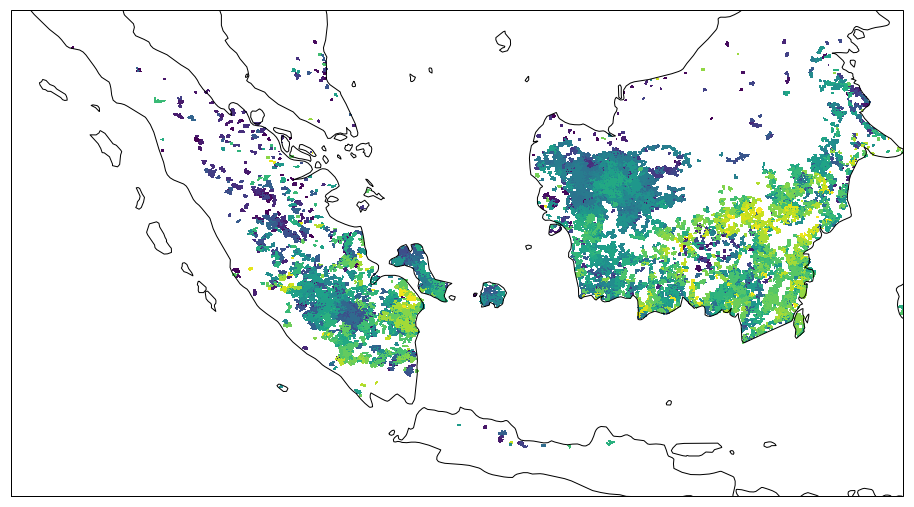

In [33]:
plt.close('all')
fig = plt.figure(figsize=(16, 12))

lat_subset = geostationary_lats[2500:3200, 600:1600]
lon_subset = geostationary_lons[2500:3200, 600:1600]
to_plot = plt_array[2500:3200, 600:1600]
to_plot = np.ma.masked_array(to_plot,  to_plot==0)

img_extent = (lon_subset[0,0], 
              lon_subset[-1,-1], 
              lat_subset[-1,-1], 
              lat_subset[0,0])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(img_extent, crs=ccrs.PlateCarree())

# set a margin around the data
# ax.set_xmargin(0.05)
# ax.set_ymargin(0.10)

# add the image. Because this image was a tif, the "origin" of the image is in the
# upper left corner
#ax.imshow(plt_array[2500:3200, 600:1600], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.pcolormesh(lon_subset, lat_subset, to_plot)

# # mark a known place to help us geo-locate ourselves
# ax.plot(-117.1625, 32.715, 'bo', markersize=7, transform=ccrs.Geodetic())
# ax.text(-117, 33, 'San Diego', transform=ccrs.Geodetic())

plt.show()

In [ ]:
plt.figure(figsize=(16,12))
plt.imshow(plt_array[2500:3200, 600:1600], cmap='tab20c', vmin=0)
plt.show()

In [100]:
plt.close('all')
anim = animate_timeseries(subset_fires_df)
HTML(anim.to_html5_video())

# Utils:

In [99]:
# Animation function

plt.close('all')

def animate_timeseries(df, interval=25):
    
    # set up the lats and the lons
    lat_subset = geostationary_lats[2500:3200, 600:1600]
    lon_subset = geostationary_lons[2500:3200, 600:1600]
    
    img_extent = (lon_subset[0,0], 
              lon_subset[-1,-1], 
              lat_subset[-1,-1], 
              lat_subset[0,0])

    
    # generat the array to plot
    to_plot = np.zeros([5500, 5500]) 
    
    # list to hold data
    lines_list = [] 
    samples_list = []
    date_list = []
    id_list = []
    
    unique_times = df.obs_time.unique()
    for i, t in enumerate(unique_times):
        
        if i < 10:
            continue
        
        t_df = df[(df.obs_time == t)]
        lines_list.append(t_df.ABS_line.values.astype(int))
        samples_list.append(t_df.ABS_samp.values.astype(int))
        date_list.append(t)
        id_list.append(t_df.fire_id.values)
        
        if i == 600:
            break

    # Create new Figure and an Axes which fills it.
    fig = plt.figure(figsize=(14, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(img_extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m', color='black', linewidth=1)

    # Build the array to plot
    to_plot[lines_list[0], samples_list[0]] = id_list[0]
    to_plot = np.ma.masked_array(to_plot,  to_plot==0)

    # plot it with pcolormesh and add in the date
    z = to_plot[2500:3200, 600:1600]
    z = z[:-1, :-1]
    quad = ax.pcolormesh(lon_subset, lat_subset, z, cmap='tab20b')
    date_text = ax.text(0.05, 0.05, '', transform=ax.transAxes)

    def update(i):
        
        my_cmap = plt.get_cmap('tab20b')
        
        # Update the quadmesh
        to_plot[lines_list[i], samples_list[i]] = id_list[i]
        z = to_plot[2500:3200, 600:1600]
        z = z[:-1, :-1]
        rav_z = z.ravel()
        quad.set_array(rav_z)
        new_color = my_cmap(rav_z)
        quad.update({'facecolors':new_color, 'edgecolors':new_color})
        date_text.set_text("Date = {}".format(date_list[i]))

    # # Construct the animation, using the update function as the animation
    # # director.
    anim = animation.FuncAnimation(fig, update, frames=len(lines_list), interval=interval)
    return anim

In [ ]:
def build_frp_df(path):
    '''

    :param path: path to the frp csv files and dataframe
    :return: dataframe holding frp
    '''
    frp_csv_files = glob.glob(path + '*.csv')
    df_from_each_file = (pd.read_csv(f) for f in frp_csv_files)
    frp_df = pd.concat(df_from_each_file, ignore_index=True)

    # keep only columns on interest
    frp_df = frp_df[['FIRE_CONFIDENCE', 'ABS_line', 'ABS_samp', 'BT_MIR', 'BT_TIR',
                     'FRP_0', 'LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'time']]

    # reindex onto date
    for k in ['year', 'month', 'day', 'time']:
        frp_df[k] = frp_df[k].astype(int).astype(str)
        if k == 'time':
            frp_df[k] = frp_df[k].str.zfill(4)
        if k in ['month', 'day']:
            frp_df[k] = frp_df[k].str.zfill(2)

    format = '%Y%m%d%H%M'
    frp_df['obs_time'] = pd.to_datetime(frp_df['year'] +
                                        frp_df['month'] +
                                        frp_df['day'] +
                                        frp_df['time'], format=format)
    frp_df['obs_date'] = frp_df['obs_time'].dt.date

    # drop columns we dont needs
    #frp_df.drop(['LONGITUDE', 'LATITUDE'], axis=1, inplace=True)
    frp_df.drop(['year', 'month', 'day', 'time'], axis=1, inplace=True)

    frp_df.to_pickle(path + 'frp_df.p')
    
build_frp_df('/Users/danielfisher/Projects/kcl-fire-aot/data/Asia/processed/himawari/updated/')

In [3]:
def geo_read(f, verbose=False):
    """
    read in the static data like view angle, landcover
    put them in a data dictionary
    """
    dim = 5500  # hard coded for Himawari8 possible it is 5500 in which case we need to zoom
    if verbose:
        print 'reading file %s' % f
    dtype = np.float32
    shape = (2, dim, dim)
    data = np.fromfile(f, dtype=dtype).reshape(shape)
    lat = data[0, :, :].astype(dtype)
    lon = data[1, :, :].astype(dtype)
    return lat, lon

Caveat/Issue List:
* May not capture a fire in its early stages
* Adjacent fires may not be related, but working under the assumption tha they are.  
